# Temperature Quantile Theory variation with latitude
This notebook looks at trying to estimate the temperature above a given quantile using each of four theories. It looks at how each of these theories work over different latitudes.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.


In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-01 11:03:35,723 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer for a given latitude bin.

In [3]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2

lat_width = 10
lat_min = np.arange(0, 90, lat_width)
lat_max = lat_min + lat_width
lat_centre = lat_min + lat_width/2  # Central absolute latitude for given latitude bin
n_lat = len(lat_min)

temp_summer_av = np.zeros((n_exp, n_lat))
ds_summer = [[], []]
for i in range(n_exp):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    for j in tqdm(range(n_lat)):
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min[j], lat_max[j]))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max[j], -lat_min[j]))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use2 = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
        ds_summer[i] += [ds_use2]
        ds_summer[i][j].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
        temp_summer_av[i, j] = ds_summer[i][j].temp[-1]

100%|██████████| 9/9 [01:24<00:00,  9.41s/it]


In [4]:
# Get data set averaged over all days exceeding a given quantile of near surface temperature in extratropics.
# Do this for each optical depth value and each latitude bin
quantile_use = 95
temp_quant = np.zeros((n_exp, n_lat))
ds_quant = [[], []]
for i in range(n_exp):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    for j in tqdm(range(n_lat)):
        ds_use2 = ds_use.where((np.abs(ds_use.lat) <= lat_max[j]) & (np.abs(ds_use.lat) >= lat_min[j]), drop=True)    # Only latitude region
        # Collapse to single coordinate and then take quantile over it
        ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        quantile_thresh = ds_use2.temp[-1].quantile(quantile_use/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use2.where(ds_use2.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        ds_quant[i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

        # Record mean extratropical near surface temperature
        temp_quant[i, j] = ds_quant[i][j].temp[-1]

100%|██████████| 9/9 [03:23<00:00, 22.57s/it]


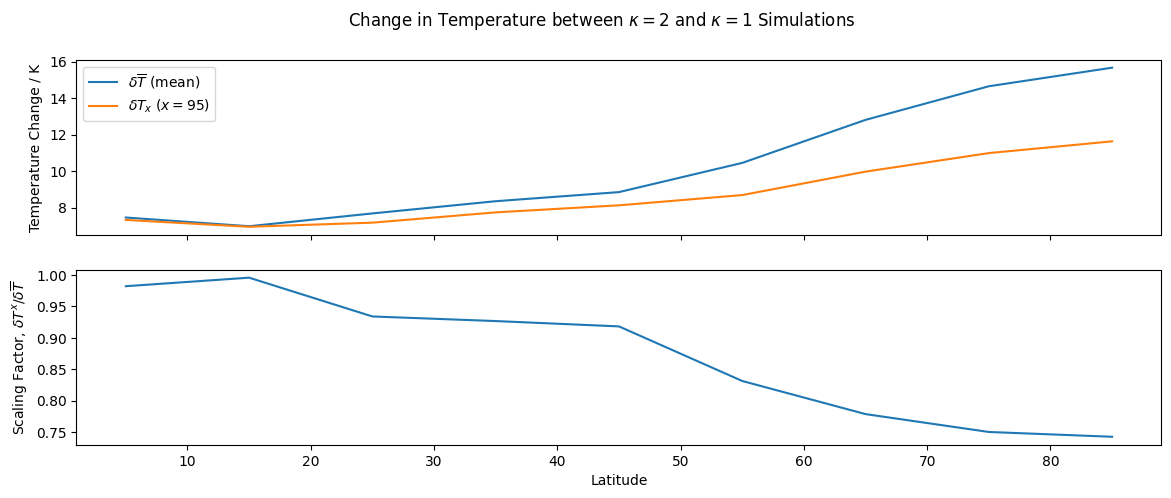

In [12]:
# In second plot here, normalise by change in the summer mean temperature
delta_temp_mean = temp_summer_av[1] - temp_summer_av[0]
delta_temp_quant = temp_quant[1]-temp_quant[0]
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(lat_centre, delta_temp_mean, label='$\delta \overline{T}$ (mean)')
ax[0].plot(lat_centre, delta_temp_quant, label=f'$\delta T_x$ ($x={quantile_use}$)')
ax[0].set_ylabel('Temperature Change / K')
ax[0].legend()
ax[1].plot(lat_centre, delta_temp_quant/delta_temp_mean)
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Latitude')
plt.suptitle(f"Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$
This is trying to get a theory for the change in temperature of a given percentile day in a manor analagous to byrne 2021.

In [17]:
p_surface = float(ds_summer[0][0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_surface_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_surface)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
# Initially thought should use the mid point for this but actually in taylor series, you evaluate at lowest (k=1) value.,
# temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_mean_mid = temp_summer_av[0]
# temp_quant_mid = np.mean(temp_all_quant, axis=0)
temp_quant_mid = temp_quant[0]

In [18]:
# Compute constants required for theory
alpha_quant = clausius_clapeyron_factor(temp_quant_mid)
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = np.asarray([np.asarray([ds_quant[i][j].sphum[-1] for j in range(n_lat)]) for i in range(n_exp)])
q_quant_mid = q_quant[0]
q_mean = np.asarray([np.asarray([ds_summer[i][j].sphum[-1] for j in range(n_lat)]) for i in range(n_exp)])
q_mean_mid = q_mean[0]
rh_quant = rh_from_sphum(q_quant,temp_quant,p_surface)/100
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_surface)/100

q_sat_quant = sphum_surface_sat(temp_quant_mid)
q_sat_mean = sphum_surface_sat(temp_mean_mid)

z_quant = np.asarray([np.asarray([ds_quant[i][j].height[-1] for j in range(n_lat)]) for i in range(n_exp)])
z_mean = np.asarray([np.asarray([ds_summer[i][j].height[-1] for j in range(n_lat)]) for i in range(n_exp)])

# Get difference in values between the two climates
delta_q_quant = q_quant[1] - q_quant[0]
delta_q_mean = q_mean[1] - q_mean[0]
delta_rh_quant = rh_quant[1] - rh_quant[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]
delta_z_quant = z_quant[1] - z_quant[0]
delta_z_mean = z_mean[1] - z_mean[0]


In [22]:
# Compute the delta h* term based on the saturation MSE in the free troposphere
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

mse_quant = np.zeros((n_exp, n_lat))
mse_ft_sat_quant = np.zeros((n_exp, n_lat))
mse_summer = np.zeros((n_exp, n_lat))
mse_ft_sat_summer = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    for j in range(n_lat):
        mse_summer[i, j] = moist_static_energy(ds_summer[i][j].temp[-1], ds_summer[i][j].sphum[-1], ds_summer[i][j].height[-1])
        mse_ft_sat_summer[i] = mse_ft(ds_summer[i][j])
        mse_quant[i, j] = moist_static_energy(ds_quant[i][j].temp[-1], ds_quant[i][j].sphum[-1], ds_quant[i][j].height[-1])
        mse_ft_sat_quant[i, j] = mse_ft(ds_quant[i][j])

mse_sat_diff = mse_ft_sat_quant - mse_ft_sat_summer
delta_mse_sat_diff = (mse_sat_diff[1] - mse_sat_diff[0]) * 1000   # *1000 so in units of J/kg

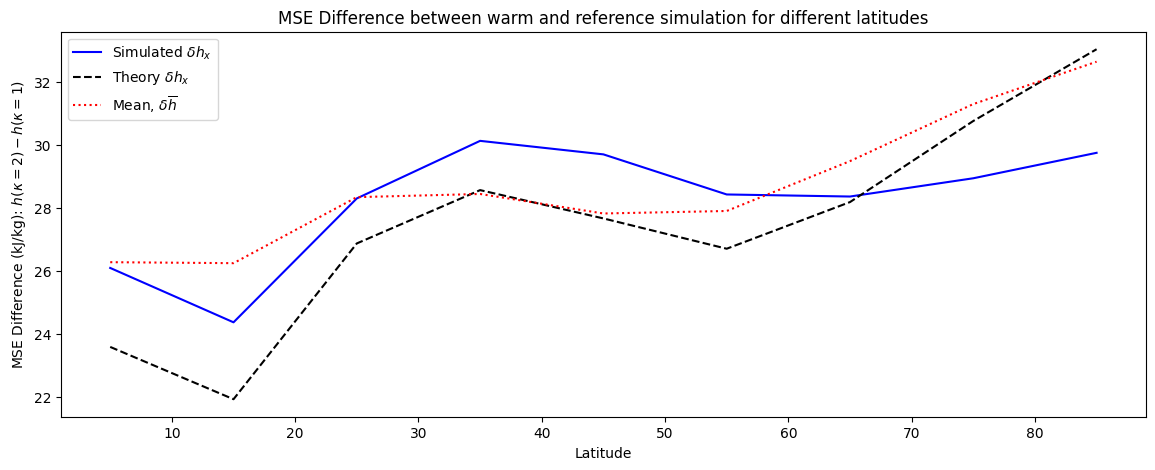

In [36]:
## Compare predicted MSE difference assuming convective neutrality to that from the theory
mse_quant_diff = mse_quant[1]-mse_quant[0]
mse_quant_diff_sim = (c_p * delta_temp_mean + L_v * delta_q_mean)/1000 + mse_sat_diff[1]-mse_sat_diff[0]
mse_summer_diff = mse_summer[1]-mse_summer[0]
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(lat_centre, mse_quant_diff, color='blue', label='Simulated $\delta h_x$')
ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
ax.set_xlabel('Latitude')
ax.set_ylabel(f'MSE Difference (kJ/kg): $h(\kappa={tau_lw_warm})-h(\kappa={tau_lw_ref})$')
ax.set_title('MSE Difference between warm and reference simulation for different latitudes')
ax.legend();

### $\delta h$ Analysis

From above, we see that the theoretical $\delta h$ assuming convective neutrality so that $h = h_{FT}$ captures the trend in $\delta h$ with latitude up to about $50\degree$ but consistently underestimates it.

I think this is because, from the convective neutrality [analysis](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/aquaplanet/k%3D1/mse_notebook.ipynb) the free troposphere MSE is always lower than the surface MSE in this latitude range and this difference increases with $\kappa$. Hence, when predicting $\delta h$ using information from the free troposphere, it is under predicted.

[ 7.3679014   7.54894839  7.16800151  7.26058764  7.57482129  8.32563373
  9.97310384 11.29763561 12.06948214]
[ 6.47722131  6.16712997  6.73565263  7.30170279  7.52834914  7.90398106
  9.45999358 11.07621869 12.25592484]


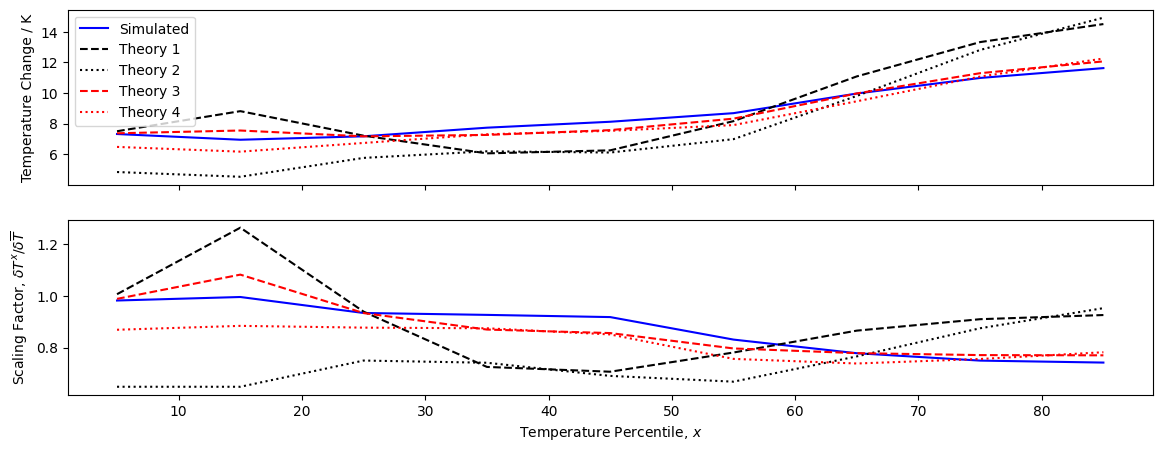

In [54]:
# Compared predicted temperature difference - Figure 2 of byrne 2021
delta_temp_quant_theory1 = delta_temp_mean + (L_v * (delta_q_mean - delta_q_quant) + g * (delta_z_mean-delta_z_quant))/c_p
delta_temp_quant_theory2 = delta_temp_quant_theory1 + delta_mse_sat_diff/c_p

denom = c_p + L_v * alpha_quant * (q_quant_mid + q_sat_quant * delta_rh_quant)
gamma_t = c_p + L_v * alpha_mean * (q_mean_mid + q_sat_mean * delta_rh_mean)

delta_temp_quant_theory3 = gamma_t * delta_temp_mean + L_v * (q_sat_mean * delta_rh_mean - q_sat_quant * delta_rh_quant) + \
                           g * (delta_z_mean - delta_z_quant)
delta_temp_quant_theory4 = delta_temp_quant_theory3 + delta_mse_sat_diff
delta_temp_quant_theory3 = delta_temp_quant_theory3 / denom
delta_temp_quant_theory4 = delta_temp_quant_theory4 / denom

# Consider adding non-linear term to theory temperature
# temp_diff_theory = temp_diff_theory + prefactor * gamma_nl * delta_rh_mean * delta_t_mean
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(lat_centre, delta_temp_quant, color='blue', label='Simulated')
ax[0].plot(lat_centre, delta_temp_quant_theory1, color='k', linestyle='--', label='Theory 1')
ax[0].plot(lat_centre, delta_temp_quant_theory2, color='k', linestyle=':', label='Theory 2')
ax[0].plot(lat_centre, delta_temp_quant_theory3, color='r', linestyle='--', label='Theory 3')
ax[0].plot(lat_centre, delta_temp_quant_theory4, color='r', linestyle=':', label='Theory 4')
ax[1].plot(lat_centre, delta_temp_quant/delta_temp_mean, color='blue', label='Simulated')
ax[1].plot(lat_centre, delta_temp_quant_theory1/delta_temp_mean, color='k', linestyle='--', label='Theory 1')
ax[1].plot(lat_centre, delta_temp_quant_theory2/delta_temp_mean, color='k', linestyle=':', label='Theory 2')
ax[1].plot(lat_centre, delta_temp_quant_theory3/delta_temp_mean, color='r', linestyle='--', label='Theory 3')
ax[1].plot(lat_centre, delta_temp_quant_theory4/delta_temp_mean, color='r', linestyle=':', label='Theory 4')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();
print(delta_temp_quant_theory3)
print(delta_temp_quant_theory4)